Start by importing numpy and matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt


Next, the main constants, boundary conditions, and thermal properties of the working fluids  are defined:

In [3]:
### CONSTANTS and BC and some constraints ### 
gravity     = 9.81          #m/s^2      @300 C 
R_g         = 8315         #J/mol-K
P_ref       = 101325        #Atmospheric Pressure

QdotShutdown = 180e3 #Heat Rejection
QdotShutdown120 = 120e3 #Heat Rejection For Alternative Case
QdotNominal = 30e3 #Heat Rejection

ThotNominal = 371 #sodium temperatue in deg C under nominal conditions
ThotShutdown = 377 #sodium temperatue in deg C under shutdown conditions
Tambient = 30 #ambient temperatue in deg C
NaKLoopReserveFraction = .25  #Reserve top 25% of the temperature budget for the NaK loop
HeatExchangerReserveFraction = .25 #Reserve bottom 25 of the delta T budget for the Air side of heat xchanger 
worstCaseDeltaTbudget = ThotNominal - Tambient
TreturnMin = ThotNominal - NaKLoopReserveFraction*worstCaseDeltaTbudget  #Min Return Temperature for the Heat Pipe
TairMax = Tambient + HeatExchangerReserveFraction*worstCaseDeltaTbudget  #Max Air Temperature out of the Heat Xchgr

deltaL  = 10        #Assumed Additional Distance Required for NaK Loop Rerouting and Viscous Loss Margin
tmp = np.zeros(5)
### MATERIAL PROPERTIES for NaK ###
rho_NaK     = 806          #kg/m^3     @300 C interpolate from Wikipedia
drho_dT_NaK = -.0002356 #kg/m^3-K    @300 C slope of Wikipedia Data
cp_NaK      = 912         #J/kg-K     @300 C 
mu_NaK      = 2.35e-4     #Pa-s       @300 C
dmu_dT_NaK  = -4.18e-7    #Pa-s/K     @300 C linear fit between 300-550 C  
k_NaK  =    22.4            #W/m-K        @300 C
T_freeze_NaK = -12.8        #C from Wikipedia 
Pr_NaK = cp_NaK*mu_NaK/k_NaK

def cPipe_rhoIDG_1atm_Tcelsius(MW,Tc):
    R_g         = 8315         #J/mol-K
    P_atm       = 101325        #Atmospheric Pressure
    rho = P_atm*MW/(R_g*(Tc+273.15))
    return rho


### MATERIAL PROPERTIES for N2 ###
MW_N2   =   28              #g/mol
rho_N2     = cPipe_rhoIDG_1atm_Tcelsius(MW_N2,300)   #kg/m^3   @300 C ifrom Ideal Gas Law
rho_N2star = cPipe_rhoIDG_1atm_Tcelsius(MW_N2,377)    #kg/m^3   @377 C ifrom Ideal Gas Law
drho_dT_N2 = (rho_N2star- rho_N2)/(377-300)    #kg/m^3-K slope between 300-377 C  from Ideal Gas Law
cp_N2      = 1040         #J/kg-K     @300 C    From Engineering Toolbox
mu_N2      = 2.8e-5       #Pa-s       @300 C    From Engineering Toolbox
mu_N2star  = 3.3e-5       #Pa-s       @377 C    From Engineering Toolbox
dmu_dT_N2  = (mu_N2star-mu_N2)/(377-300)    #Pa-s/K     @300 C linear fit between 300-377 C  
k_N2       = .045         #W/m-K        @300    From Engineering Toolbox
Pr_N2 = cp_N2*mu_N2/k_N2

print(f'Pr_NaK: {Pr_NaK:.3f}\t Pr_N2: {Pr_N2:.3f}\t Ratio of Pr_N2/Pr_NaK: {Pr_N2/Pr_NaK:.3f}')


Pr_NaK: 0.010	 Pr_N2: 0.647	 Ratio of Pr_N2/Pr_NaK: 67.634


Next the defined flow solving functions are defined including:
1) the colebrook implicit function of friction factor, Reynolds Number, and roughness ratio 
2) the solver function to solve equation 1)
3) the friction factor retreival function to either call the colebrook function or get the laminar friction as f(Re)
4) a plotting function to check that functions 1-3 are working and match the moody chart

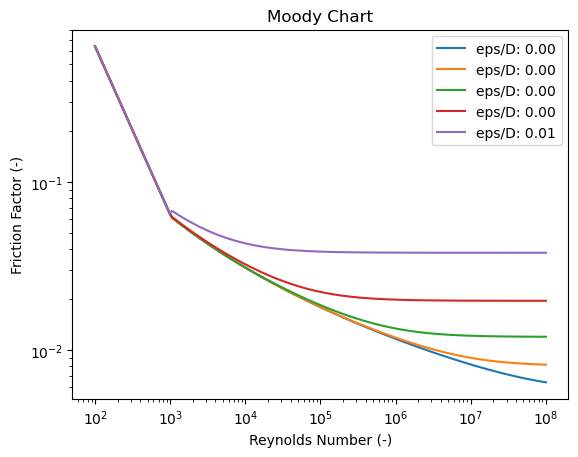

In [4]:
def cPipe_ColebrookEqualsZeroIfCorrect(Re,epsOverD,fd):
    return -2.0*np.sqrt(fd)*np.log10(epsOverD/3.7+2.5/(Re*np.sqrt(fd)))-1.0

def cPipe_solveImplicitColebrook(Re,epsOverD,f0=0.03):
    fstep = 1.001
    solverURF = .3
    tolerance = 1e-6
    Err = cPipe_ColebrookEqualsZeroIfCorrect(Re,epsOverD,f0)
    nSteps = 0
    while abs(Err) > tolerance:
        Err = cPipe_ColebrookEqualsZeroIfCorrect(Re,epsOverD,f0)
        dErr_df = (cPipe_ColebrookEqualsZeroIfCorrect(Re,epsOverD,f0*fstep)-Err)/(f0*(fstep-1.0))
        f1 = f0 - Err/dErr_df
        f0 = f0*(1-solverURF) + solverURF*f1
        
        nSteps += 1
        if nSteps > 200:
            return 1.0
    return f0

def cPipe_getFrictionFactor(Re,epsOverD=0,f0=0.03):
    ReTransition = 1000

    if Re < ReTransition:
        f_d = 64/Re
    else:
        f_d = cPipe_solveImplicitColebrook(Re,epsOverD,f0)
    return f_d

def cPipe_myLogSpace(a,b,n):
    alpha = np.power(b/a,1/(n-1))
    vec = np.zeros(n)
    for i in range(0,n):
        vec[i] = a*np.power(alpha,i)
    return vec

def cPipe_plotMoodyChart(ReVals,epsVals):
    n = len(ReVals)
    m = len(epsVals)
    fvals_forChart = np.zeros([n,m])
    f0= 0.03
    for i,Re in enumerate(ReVals):
        for j,eps in enumerate(epsVals):
            f0 = cPipe_getFrictionFactor(Re,eps,f0)
            fvals_forChart[i,j] = f0


    for j, eps in enumerate(epsVals):
        plt.loglog(ReVals, fvals_forChart[:,j], '-', label=f'eps/D: {eps:.2f}')
    plt.xlabel('Reynolds Number (-)')
    plt.ylabel('Friction Factor (-)')
    plt.title('Moody Chart')
    plt.legend()

    plt.show()
    pass 

cPipe_plotMoodyChart(cPipe_myLogSpace(100,1e8,200),cPipe_myLogSpace(1e-6,1e-2,5))

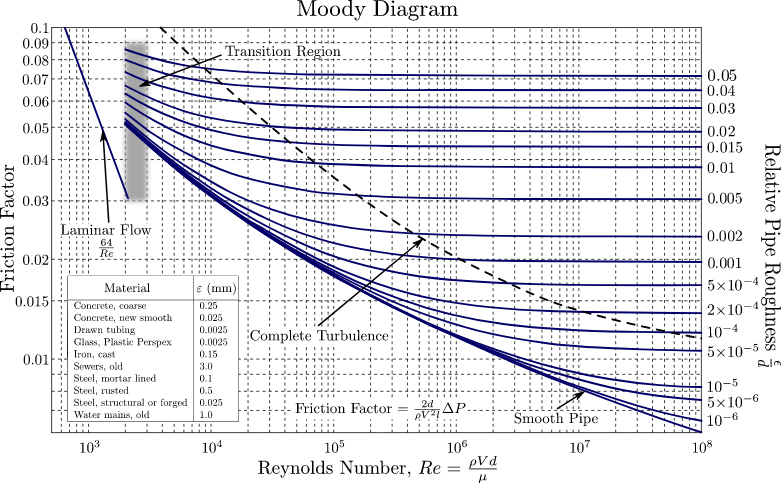

Next come the additional helper functions to:
5) Solve for the pressure loss in a pipe and the friction factor given a bulk velocity, rho, mu, Diam, and a guessed f 
6) Iteratively for the pipe velocity and friction factor given delta_P, rho, mu, L, D, eps, and a guessed f
7) Iteratively solve the full loop given, the heat rate, initial temperature, and parameters for linearly varying thermal properties rho and mu

In [8]:
def cPipe_calcPressureLoss(Velocity,rho,mu,Diam,Length,eps=0,f0=.03):
    Re = rho*Velocity*Diam/mu
    f0 = cPipe_getFrictionFactor(Re,eps/Diam,f0)
    return rho*Velocity*Velocity*Length*f0/(2*Diam), f0


def cPipe_solvePipeVelocity(deltaP,rho,mu,Length,Diam,eps=0,fguess=0.03):
    if deltaP < 0:
        deltaP = -1*deltaP
    U0 = 0.01
    dP0,f0 = cPipe_calcPressureLoss(U0,rho,mu,Diam,Length,eps,fguess)
    Ustep = 1.001
    solverURF = .5
    tolerance = 1e-4
    Err = (dP0 - deltaP)/deltaP
    nSteps =0
    while abs(Err) > tolerance:
        dPstar, f0 = cPipe_calcPressureLoss(U0*Ustep,rho,mu,Diam,Length,eps,f0)
        ErrStar = (dPstar - deltaP)/deltaP
        dErr_dU = (ErrStar-Err)/(U0*(Ustep-1.0))
        U1 = U0 - Err/dErr_dU
        U0 = U0*(1-solverURF) + solverURF*U1
        U0 = max(1e-4,U0)
        dP0, f0 = cPipe_calcPressureLoss(U0,rho,mu,Diam,Length,eps,f0)
        Err = (dP0-deltaP)/deltaP
        nSteps += 1
        if nSteps > 100:
            return 1.0,1.0
        #print(U0,U1,f0, Err)

    return U0, f0


def cPipe_solveBuoyantFlowLoop(Qdot,Thot, rho, drho_dT, cp, mu, dmu_dT, U0, pipeDiam, totalPipeLength, deltaH, f0=.03):
    #f0 = 0.03
    gravity = 9.81                                 
    solverURF = .3
    tolerance = 1e-4
    Err = 1
    steps = 0
    maxSteps = 50
    Apipe = np.pi*0.25*np.power(pipeDiam,2)
    while abs(Err) > tolerance and steps < maxSteps:
        steps +=1
        mdot0 = rho*U0*Apipe                  # Flow Rate kg/s
        deltaT = Qdot/(mdot0*cp)   #temperature change across heat exchanger
        Tcold = Thot-deltaT
        delta_rho = -1*deltaT*drho_dT         # NaK density change responsible for driving natural convection
        deltaP = delta_rho*gravity*deltaH       # Natural Convection driving pressure
        rhoCold = rho + drho_dT*(Tcold-300)
        rhoHot =  rho + drho_dT*(Thot-300)
        muCold = mu + dmu_dT*(Tcold-300)
        muHot =  mu + dmu_dT*(Thot-300)
        rhoEff = 0.5*(rhoCold + rhoHot)   # average density in the flow loop
        muEff  = 0.5*(muCold + muHot)      # average viscosity in the flow loop    
        U1,f0 = cPipe_solvePipeVelocity(deltaP,rhoEff,muEff,totalPipeLength,pipeDiam,0,f0)  #Calculate the updated velocity and
        U0 = U0*(1-solverURF)+U1*solverURF
        Err = U1-U0
    #print('Step: ',steps,' Err: ',Err,' U0: ',U0,' f0: ',f0,' U1: ',U1,' deltaT: ',deltaT,' Tcold: ',Tcold)
    return mdot0, U1, Tcold, rhoEff, muEff, f0

#Run a check for a pipe of 0.5m diameter, 10m column diameter, and total pipe length 25m and NaK as the working fluid
D_check = 0.5
deltaH_check = 10
L_total_check = 25
mdot0, U1, Tcold, rhoEff, muEff, f0 = cPipe_solveBuoyantFlowLoop(QdotShutdown,ThotShutdown, rho_NaK, drho_dT_NaK, cp_NaK, mu_NaK, dmu_dT_NaK, 1.0, D_check, L_total_check, deltaH_check, f0=.03)
print(f'Check Solution: MassFlow: {mdot0:.3f} (kg/s)\t Bulk Velocity: {U1:.3f} (m/s)\t Return Temperature: {Tcold:.1f} C\t Friction Factor: {f0:.3f} (-)')


Check Solution: MassFlow: 6.726 (kg/s)	 Bulk Velocity: 0.042 (m/s)	 Return Temperature: 347.7 C	 Friction Factor: 0.019 (-)


Next we want to do an initial exploration of the design space by calculating the (cold) return Temperature running a 2D parameter sweep on pipeDiameter (from 0.01m to 1.0m) and column height (from 1m to 20m) to understand where the return temperature will be within budget and whether the return temperature is higher or lower for the Nominal case relative to the shutdown case

Running Sweep on Column Height: 1.00 m
Running Sweep on Column Height: 1.39 m
Running Sweep on Column Height: 1.95 m
Running Sweep on Column Height: 2.71 m
Running Sweep on Column Height: 3.79 m
Running Sweep on Column Height: 5.28 m
Running Sweep on Column Height: 7.37 m
Running Sweep on Column Height: 10.28 m
Running Sweep on Column Height: 14.34 m
Running Sweep on Column Height: 20.00 m


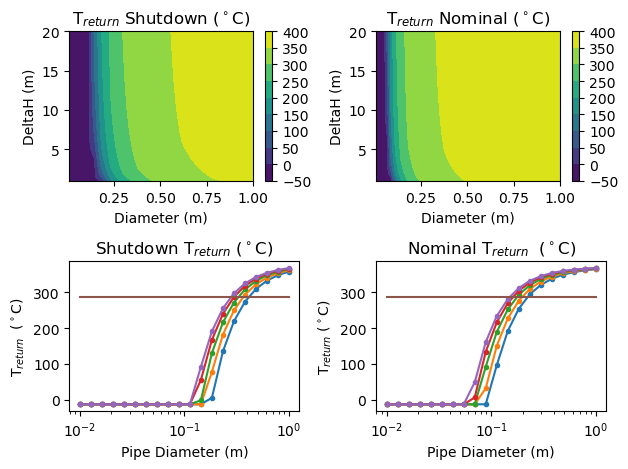

In [22]:
nPipePts = 20
nHpts = 10
pipeDiams = cPipe_myLogSpace(.01,1.0,nPipePts)
deltaHs   = cPipe_myLogSpace(1,20,nHpts)
dGrid = np.zeros([nPipePts,nHpts])
dHGrid = np.zeros([nPipePts,nHpts])
TreturnShutdownGrid = np.zeros([nPipePts,nHpts])
TreturnNominalGrid = np.zeros([nPipePts,nHpts])
for j, deltaH in enumerate(deltaHs):
    print(f'Running Sweep at Column Height: {deltaH:.2f} m')
    for i, pipeDiam in enumerate(pipeDiams):
        totalPipeLength = 2*(deltaH+deltaL)
        dGrid[i,j]=pipeDiam 
        dHGrid[i,j]=deltaH
        mdotShutdown, Ushutdown, TreturnShutdown, rhoShutdown, muShutdown, f0  = cPipe_solveBuoyantFlowLoop(QdotShutdown, ThotShutdown, rho_NaK, drho_dT_NaK, cp_NaK, mu_NaK, dmu_dT_NaK, 1.0, pipeDiam, totalPipeLength, deltaH,.03)
        mdotNominal, UNominal, TreturnNominal, rhoNominal, muNominal, f0       = cPipe_solveBuoyantFlowLoop(QdotNominal, ThotNominal, rho_NaK, drho_dT_NaK,  cp_NaK, mu_NaK, dmu_dT_NaK, 1.0, pipeDiam, totalPipeLength, deltaH,.03)
        TreturnShutdownGrid[i,j]=max(TreturnShutdown,T_freeze_NaK)
        TreturnNominalGrid[i,j]=max(TreturnNominal,T_freeze_NaK)
        #print(f'deltaH: {deltaH:.2f} m \t Pipe Diameter: {pipeDiam:.3f} m\t Return Temperatures- Shutdown: {TreturnShutdown:.1f} C {TreturnNominal:.1f} C')

fig2 = plt.figure()
ax1 = fig2.add_subplot(221)
plt.contourf(dGrid,dHGrid,TreturnShutdownGrid)
ax1.set_xlabel('Diameter (m)')
ax1.set_ylabel('DeltaH (m)')
plt.title('Shutdown T$_{return}$ ($^\circ$C)')
plt.colorbar()

ax2 = fig2.add_subplot(222)
plt.contourf(dGrid,dHGrid,TreturnNominalGrid)
ax2.set_xlabel('Diameter (m)')
ax2.set_ylabel('DeltaH (m)')
plt.title('Nominal T$_{return}$ ($^\circ$C)')
plt.colorbar()

ax3 = fig2.add_subplot(223)
for j in range(0,len(deltaHs),2):
    ax3.semilogx(pipeDiams, TreturnShutdownGrid[:,j], '.-', label=r' $\Delta $_$H}$: '+f'{deltaHs[j]:.2f}m')
ax3.semilogx(pipeDiams, TreturnMin*np.ones(len(pipeDiams)),label='Minimum Return Temperature')
plt.xlabel('Pipe Diameter (m)')
plt.ylabel('T$_{return}$  ($^\circ$C)')
plt.title('Shutdown T$_{return}$ ($^\circ$C)')
#plt.legend()

ax4 = fig2.add_subplot(224)
for j in range(0,len(deltaHs),2):
    ax4.semilogx(pipeDiams, TreturnNominalGrid[:,j], '.-', label=r' $\Delta $_$H}$: '+f'{deltaHs[j]:.2f}m')
ax4.semilogx(pipeDiams, TreturnMin*np.ones(len(pipeDiams)),label='Minimum Return Temperature')
plt.xlabel('Pipe Diameter (m)')
plt.ylabel('T$_{return}$ ($^\circ$C)')
plt.title('Nominal T$_{return}$  ($^\circ$C)')
#plt.legend()


fig2.tight_layout()



Where it is clear that the dominating design variable is the pipe diameter with relatively little insensitivity to the column height above 10m. Additionally, the return Temperature in the baseline Nominal case (30kW per cooler) is always higher than the Shutdown case (180kW per cooler) so focusing on the Shutdown case as the worst case scenario is warranted. 

To compare the difference between 2 and 3 shutdown coolers oving forward we assume a column height of 10m +/- 1m and increase the pipe diameter until the minimum return temperature is reached to estimate the sensitivity of the optimal pipe diameter to the column height parameter:


Running Sweep at Column Height: 10.00 m
.......................................................................................................................................................
120kW Case: Pipe Diam.: 0.249 m   MassFlow: 1.470 (kg/s)  Bulk Vel. : 0.037 (m/s)  Re: 33884.4 C	 f: 0.018 (-)
180kW Case: Pipe Diam.: 0.286 m   MassFlow: 2.164 (kg/s)  Bulk Vel.: 0.042 (m/s)   Re: 43272.8 C	 f: 0.017 (-)


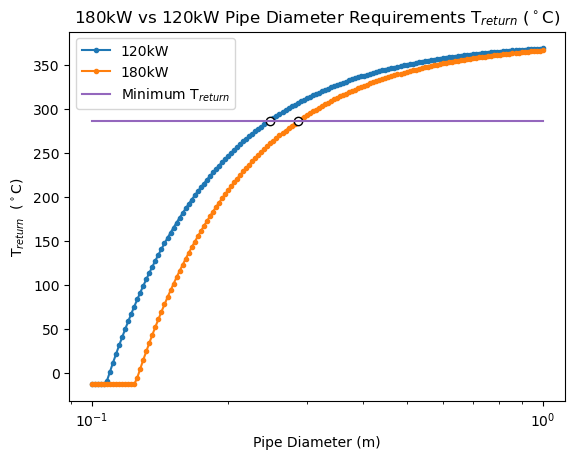

In [41]:
nPipePts = 150
pipeDiams = cPipe_myLogSpace(.1,1.0,nPipePts)
deltaHs   = [10]
nHpts = len(deltaHs)
dGrid = np.zeros([nPipePts,nHpts])
dHGrid = np.zeros([nPipePts,nHpts])
TreturnShutdownGrid180 = np.zeros([nPipePts,nHpts])
TreturnShutdownGrid120 = np.zeros([nPipePts,nHpts])

for j, deltaH in enumerate(deltaHs):
    print(f'Running Sweep at Column Height: {deltaH:.2f} m')
    first180flag =0
    first120flag =0
    for i, pipeDiam in enumerate(pipeDiams):
        print('.',end='')
        totalPipeLength = 2*(deltaH+deltaL)
        dGrid[i,j]=pipeDiam 
        dHGrid[i,j]=deltaH
        mdotShutdown180, Ushutdown180, TreturnShutdown180, rhoShutdown180, muShutdown180, f180  = cPipe_solveBuoyantFlowLoop(QdotShutdown, ThotShutdown, rho_NaK, drho_dT_NaK, cp_NaK, mu_NaK, dmu_dT_NaK, 1.0, pipeDiam, totalPipeLength, deltaH,.03)
        mdotShutdown120, Ushutdown120, TreturnShutdown120, rhoShutdown120, muShutdown120, f120       = cPipe_solveBuoyantFlowLoop(QdotShutdown120, ThotShutdown, rho_NaK, drho_dT_NaK,  cp_NaK, mu_NaK, dmu_dT_NaK, 1.0, pipeDiam, totalPipeLength, deltaH,.03)
        TreturnShutdownGrid180[i,j] =max(TreturnShutdown180,T_freeze_NaK)
        TreturnShutdownGrid120[i,j] =max(TreturnShutdown120,T_freeze_NaK)
        if TreturnShutdown120 > TreturnMin and first120flag ==0:
            first120flag = 1
            mdot120, U120, Tr120, rho120, mu120, f120 = mdotShutdown120, Ushutdown120, TreturnShutdown120, rhoShutdown120, muShutdown120, f120
            diam120 = pipeDiam
            Re120 = rho120*U120*diam120/mu120
        if TreturnShutdown180 > TreturnMin and first180flag ==0:
            first180flag = 1
            mdot180, U180, Tr180, rho180, mu180, f180 = mdotShutdown180, Ushutdown180, TreturnShutdown180, rhoShutdown180, muShutdown180, f180 
            diam180 = pipeDiam
            Re180 = rho180*U180*diam180/mu180
    print('.')        
#print(f'120kW Case- Pipe Diameter: {diam120:.3f} m\t Mass Flow: {Tr120:.1f} C {TreturnNominal:.1f} C')
print(f'120kW Case: Pipe Diam.: {diam120:.3f} m   MassFlow: {mdot120:.3f} (kg/s)  Bulk Vel. : {U120:.3f} (m/s)  Re: {Re120:.1f} C\t f: {f120:.3f} (-)')
print(f'180kW Case: Pipe Diam.: {diam180:.3f} m   MassFlow: {mdot180:.3f} (kg/s)  Bulk Vel.: {U180:.3f} (m/s)   Re: {Re180:.1f} C\t f: {f180:.3f} (-)')
        
fig3 = plt.figure()
plt.semilogx(pipeDiams, TreturnShutdownGrid120,'.-', label=r'120kW')
plt.semilogx(pipeDiams, TreturnShutdownGrid180,'.-', label=r'180kW')
plt.semilogx(diam180, TreturnMin,marker="o",markeredgecolor="black", markerfacecolor="white")
plt.semilogx(diam120, TreturnMin,marker="o",markeredgecolor="black", markerfacecolor="white")
plt.semilogx(pipeDiams, TreturnMin*np.ones(len(pipeDiams)),label='Minimum T$_{return}$')
plt.xlabel('Pipe Diameter (m)')
plt.ylabel('T$_{return}$  ($^\circ$C)')
plt.title('180kW vs 120kW Pipe Diameter Requirements T$_{return}$ ($^\circ$C)')
plt.legend()



With Diameters fixed for the 180kW and 120kw, the heat exchanger can be considered:


In [44]:
def cPipe_heatExchangerDesign(Qdot,Thot,Treturn,Tambient,Dpipe):
    cp_air = 1040                       #Specific Heat of Air
    h_conv = 7                          #Convective Heat Transfer Coefficient of Natural Convection in Air
    MW_air = 28.2                       #Molecular Weight of Air
    gravity = 9.81     
    tube_over_pipe_sectionArea = 2          #Ratio of total tube to NaK pipe cross-section areas 
    blockage_ratio = 0.5                #Fraction of Air Cross Section Blocked by Tubes        
    rho_air = cPipe_rhoIDG_1atm_Tcelsius(MW_air, Tambient)    #Air Density at Ambient Temperature and 1atm
    T_tubeAvg = 0.5*(Thot+Treturn)                      #Average Temparature from NaK Available for Heat Xfer
    deltaTairNaK = T_tubeAvg-Tambient                   #Average Temperature Difference Driving Heat Xfer from NaK to Air
    deltaTairair = 0.25*deltaTairNaK                    #Air temperature rise across heat exchanger limited to .25 of available delta T
    rho_airOut = cPipe_rhoIDG_1atm_Tcelsius(MW_air, Tambient+deltaTairair)  #air density after heat exchanger
    AtubesOuter = Qdot/(deltaTairNaK*h_conv)            #Total Tube Surface Area required to reject Qdot given delta T and h
    mdotAir = Qdot/(deltaTairair*cp_air)                #Mass flow of air required to limit deltaTairair from exceeding constraint
    Across_pipe = 0.25*np.pi*np.power(Dpipe,2)          #Cross-sectional are of NaK pipe
    Across_Alltubes = tube_over_pipe_sectionArea*Across_pipe
    
    dMin = .005
    dMax = .05
    nDiams = 20
    bestMaxDimension = 1e6
    allDiams = cPipe_myLogSpace(dMin, dMax, nDiams)   #list of all diameters to be checked
    for diam in allDiams:
        A_per_tube = np.pi*0.25*np.power(diam,2)    #Cross sectional Area per tube 
        N_tubes = Across_Alltubes/A_per_tube        #N tubes
        W = diam*np.sqrt(N_tubes)/blockage_ratio             #Total Width of Heat Exchanger 
        L =  AtubesOuter/(np.pi*diam*N_tubes)       #Tube Length To Give Required Surface Area
        A_open = L*W*blockage_ratio                 #Total Area of Heat Exchanger Open for Air Flow
        U_open = mdotAir/(rho_air*A_open)           #Air Velocity at minimum cross-section (Between Tubes)
        KE_air = 0.5*rho_air*np.power(U_open,2)     #Kinetic Energy of Air at minimum cross section
        H = W+KE_air/(0.5*gravity*(rho_air-rho_airOut))   #Stack Height required to supply necessary KE_air
        maxDimension = max(L,W,H)
        #print('Diam**: ',diam, N_tubes, L, W, H, maxDimension)
        if maxDimension < bestMaxDimension:                           #find diameter that minimizes total heat exchanger volume
            bestD, bestN, bestL, bestW, bestH, bestMaxDimension = diam, N_tubes, L, W, H, maxDimension    
            #print('Diam**: ',diam, N_tubes, L, W, H, maxDimension)
    return bestD, bestN, bestL, bestW, bestH, bestMaxDimension

tubeD180, N180, L180, Wxchg180, bestHxchg180, bestMaxDimension180 = cPipe_heatExchangerDesign(QdotShutdown,ThotShutdown,Tr180,Tambient,diam180)
tubeD120, N120, L120, Wxchg120, bestHxchg120, bestMaxDimension120 = cPipe_heatExchangerDesign(QdotShutdown120,ThotShutdown,Tr120,Tambient,diam120)
print(tubeD180, N180, L180, Wxchg180, bestHxchg180, bestMaxDimension180)
print(tubeD120, N120, L120, Wxchg120, bestHxchg120, bestMaxDimension120)

0.016799091431418913 579.7090574492728 2.7886284517991293 0.8089484224606385 2.461614840045688 2.7886284517991293
0.014881757208156592 559.3296922760544 2.168895846971886 0.7039116416693558 2.294854335831404 2.294854335831404
